## Lib import statements

In [3]:
import matplotlib.pyplot as plt    # MatPlotLib is a plotting package. 
import numpy as np                 # NumPy is a numerical types package.
from scipy import stats            # ScPy is a scientific computing package. We just want the stats, because Ca2+ imaging is always calculated in z-score.
from scipy.stats import circmean
import math
from posixpath import join

# Setup in-notebook plotting:
%matplotlib inline

## Object definition

In [24]:
#@title LIF Model

# Define LIF neurons:
class LIF_Network:
  def __init__(self, n_neurons = 1000, dimensions = [[0,100],[0,100],[0,100]]):
    # Neuron count
    self.n_neurons = n_neurons
    
    # spatial organization.
    self.dimensions = dimensions;
    self.x = np.random.uniform(low=self.dimensions[0][0], high=self.dimensions[0][1], size=(self.n_neurons,))
    self.y = np.random.uniform(low=self.dimensions[1][0], high=self.dimensions[1][1], size=(self.n_neurons,))
    self.z = np.random.uniform(low=self.dimensions[2][0], high=self.dimensions[2][1], size=(self.n_neurons,))

    # internal time trackers
    self.t = 0                 # current time [ms]
    self.dt = .1               # time step [ms]
    self.t_itt = 0             # time index
    self.relax_time = 10000    # length of relaxation phase [ms]

    # electrophysiology values
    self.v = np.random.uniform(low=-10, high=10, size=(self.n_neurons,)) - 45               #  internal voltage [mV]
    self.v_rest = -38                                                                       #  the resting voltage, equilibrium [mV] def: -38

    self.v_thr = np.ones([self.n_neurons,]) * -40                                           #  reversal potential for spiking [mV]
    self.v_rf_thr = np.ones([self.n_neurons,]) * -40                                        #  reversal potential for spiking during refractory period [mV]
    self.v_rf_tau = 5                                                                       #  the relaxation tau between refractory and normal thresholds.

    self.v_reset = -67                                                                      #  the reset, overshoot voltage [mV]
    self.v_spike = 20                                                                       #  the voltage that spikes rise to [mV]
    self.v_rf_spike = 0                                                                     #  the threshold that changes in the refractory period [mV]
    self.spike_length = 1
    self.spike_flag = np.zeros([self.n_neurons,])
    self.t_spike1 = np.zeros([self.n_neurons,]) - 10000
    self.t_spike2 = np.zeros([self.n_neurons,]) - 10000
    self.spike_record = np.empty(shape=[1,2])
    self.g_leak = 10                                                                        #  the conductance of the leak channels [nS]

    tau_c1 = np.sqrt(-2 * np.log(np.random.random(size=(self.n_neurons,))))                 #  membrane time-constant component 1
    tau_c2 = np.cos(2 * np.pi * np.random.random(size=(self.n_neurons,)))                   #  membrane time-constant component 2                                               
    self.m_tau = 7.5 * tau_c1 * tau_c2 + 150                                                #  the membrane time-constant [ms]

    self.syn_tau = 1                                                                        #  the synaptic time-constant [ms]
    self.v_syn = 0                                                                          #  the voltage synapses push the cell membrane towards [mV]
    self.syn_g = np.zeros([self.n_neurons,])                                                #  dynamic tracker of synaptic conductance.
    
    self.g_poisson = 1.3                                                                    #  the conductance of the extrinsic poisson inputs.
    self.poisson_freq = 20 * self.dt * .001                                                 #  poisson input frequency
    self.poisson_input = np.zeros([self.n_neurons,])                                        #  the input vector from external noise
    self.noise_g = np.zeros([self.n_neurons,])                                              #  dynamic tracker of noise conductance.

    # STDP paramters
    self.stdp_beta = 1.4                                                                    #  the balance factor for LTP and LTD
    self.stdp_tau_R = 4                                                                     #  used for the negative half of STDP
    self.stdp_tau_plus = 10                                                                 #  used for the postive half of STDP
    self.stdp_tau_neg = self.stdp_tau_R * self.stdp_tau_plus                                #  used for the negative half of STDP

    self.lamda = 0.02
    self.w_flag = np.zeros([self.n_neurons,])
    
    # Connectivity parameters
    self.p_conn = .07                                                                       #  probability of presynaptic connections from other neurons.
    self.mean_w = 0.5                                                                       #  mean conductance of synapses.
    self.synaptic_delay = 3                                                                 #  the amount of time an AP takes to propogate [ms]. def: 3
    C = 400
    self.network_coupling = C/self.n_neurons                                                #  coupling strength of extrinsic input noise?
    self.network_input = np.zeros([self.n_neurons,])                                        #  dynamic tracker of synaptic inputs
    self.external_strength = C/5
    self.network_conn = np.zeros([self.n_neurons,self.n_neurons])                           #  network connectivity
    self.network_W = np.random.random(size=(self.n_neurons,self.n_neurons)) 
    self.random_conn()

  def random_conn(self,):
    pc = np.random.random(size=(self.n_neurons,self.n_neurons))
    self.network_conn = pc < self.p_conn
    self.network_W = np.random.random(size=(self.n_neurons,self.n_neurons))
    self.network_W[self.network_conn == 0] = 0
    self.network_W = self.network_W/np.mean(self.network_W[self.network_W > 0]) * self.mean_w
    self.network_W[self.network_W > 1] = 1
    self.network_W[self.network_W < 0] = 0

  # Jesse note: this function can be matrix-ized to save processing time. # To do.
  def structured_conn(self,LIF,):
    self.network_conn = np.zeros([self.n_neurons,self.n_neurons])  
    dist=np.empty([self.n_neurons,self.n_neurons])
    dist[:] = np.nan
    dist1=[]
    c=[]
    for f in range(LIF.n_neurons-1):
      i=f
      for j in range(f+1,LIF.n_neurons,1):
        a=(LIF.x[i]-LIF.x[j])*(LIF.x[i]-LIF.x[j])+(LIF.y[i]-LIF.y[j])*(LIF.y[i]-LIF.y[j])+(LIF.z[i]-LIF.z[j])*(LIF.z[i]-LIF.z[j])
        b=np.sqrt(a)
        c.append(b)
      #print('distance between neurons', i+1, 'and', j+1, ': ', b)
    d=sum(c)/len(c)
    print('The average distance between neurons in this network is:', d)
    print('The base of the exponent is:', LIF.p_conn**(1/d))
    bb=[]
    cc=[]
    for p in range(LIF.n_neurons):
      for p2 in range(LIF.n_neurons):
        if(p!=p2):
          a=(LIF.x[p]-LIF.x[p2])*(LIF.x[p]-LIF.x[p2])+(LIF.y[p]-LIF.y[p2])*(LIF.y[p]-LIF.y[p2])+(LIF.z[p]-LIF.z[p2])*(LIF.z[p]-LIF.z[p2])
          b=np.sqrt(a)
          dist1.append(b)
    for p in range(LIF.n_neurons):
      for p2 in range(LIF.n_neurons):
        if(p!=p2):
          a=(LIF.x[p]-LIF.x[p2])*(LIF.x[p]-LIF.x[p2])+(LIF.y[p]-LIF.y[p2])*(LIF.y[p]-LIF.y[p2])+(LIF.z[p]-LIF.z[p2])*(LIF.z[p]-LIF.z[p2])
          b=np.sqrt(a)
          #aa=((LIF.p_conn**(1/d)) ** b)
          aa=2.71828**(-b/(LIF.p_conn*max(dist1)))
          pc = np.random.random(size=(1,))
          if(pc<aa):
            self.network_conn[p][p2] = 1
            dist[p][p2]=b
    return dist
    self.network_W = np.random.random(size=(self.n_neurons,self.n_neurons))
    self.network_W[self.network_conn == 0] = 0
    self.network_W = self.network_W/np.mean(self.network_W[self.network_W > 0]) * self.mean_w
    self.network_W[self.network_W > 1] = 1
    self.network_W[self.network_W < 0] = 0

  def simulate_poisson(self,):
    self.poisson_input = 1 * (np.random.rand(self.n_neurons,) < self.poisson_freq)
  
  def assaySTDP(self):
    %matplotlib inline
    fig = plt.figure()

    for i in range(-100,100,1):
      plt.scatter(i,self.Delta_W_tau(i,0,0),s=2,c='k')

    plt.ylabel('dW')
    plt.xlabel('time offset (pre - post)')
    plt.title('STDP curve')
    plt.show()
    self.random_conn()
    
  def Delta_W_tau(self,time_diff,i,j):
    dW = 0
    if time_diff < -0.01:
      dW = self.lamda * np.exp( time_diff / self.stdp_tau_plus )
      print(f"{' '*10} LTP, dW = {dW}")
    
    if time_diff > 0.01:
      dW = -(self.stdp_beta/self.stdp_tau_R) * self.lamda * np.exp( -time_diff / self.stdp_tau_neg)
      print(f"{' '*10} LTD, dW = {dW}")

    self.network_W[i][j] = self.network_W[i][j] + dW
    self.network_W[self.network_W > 1] = 1
    self.network_W[self.network_W < 0] = 0
    return dW

  def spikeTrain(self,lookBack=None, nNeurons = 5, purge=False, tnorm = False):
    if lookBack is None:
      lookBack = self.t
    lb = lookBack
    lookBack = self.t - lookBack

    SR = np.reshape(self.spike_record,newshape = [-1,2])
    SR = np.delete(SR, 0, 0)
    SRix = np.argmax(SR[:,1] >= lookBack)
    SR = SR[SRix:,:]
    
    %matplotlib inline
    fig = plt.figure()
    if tnorm:
      plt.plot([0, lb],[0,nNeurons],'white')
    else:
      plt.plot([lookBack-self.t+lookBack, self.t-self.t+lookBack],[0,nNeurons],'white')
    for i in range(nNeurons):
      result = np.array(np.where(SR[:,0] == i)).flatten()
      for q in range(len(result)):
        loc = result[q]
        if (SR[loc,1]) >= lookBack:
          if tnorm:
            plt.plot([SR[loc,1]-self.t+lb, SR[loc,1]-self.t+lb],[i,i+.9],'k',linewidth=.5)
          else:
            plt.plot([SR[loc,1], SR[loc,1]],[i,i+.9],'k',linewidth=.5)
    
    plt.xlabel('time (ms)')
    plt.ylabel('neuron #')
    fig.set_size_inches(5, 4)
    plt.rcParams.update({'font.size': 22})
    plt.show()

    if purge:
      self.spike_record = np.empty(shape=[1,2])
    
    return SR

  def vect_kuramato(self,period=None,lookBack=None, r_cutoff = .3):
    if period is None:
      period=100/self.dt # 100 milliseconds.
    if lookBack is None:
      lookBack = self.t
    lb = self.t - lookBack

    # Spike record
    SR = np.reshape(self.spike_record,newshape = [-1,2])
    SR = np.delete(SR, 0, 0)
    SRix = np.argmax(SR[:,1] >= lb)
    SR = SR[SRix:,:]
    SR = sorted(SR,key=lambda x: x[0])
    wraps = lookBack/period

    N = self.n_neurons
  
    theta = np.random.normal(size=[N,])
    phasespace = np.linspace(0,2*np.pi,int(period+1))

    held_neuron = np.min(SR[:][0])
    phase_entries = []
    phase_medians = np.zeros(shape=[N,])
    for i in range(len(SR)):
      ix = SR[i][0]
      if ix != held_neuron:
        x = np.cos(phase_entries)
        y = np.sin(phase_entries)
        mx = np.mean(x)
        my = np.mean(y)
        rho = np.sqrt(mx**2 + my**2)
        phi = np.arctan2(my, mx)
        if rho >= r_cutoff:
          phase_medians[int(ix)] = phi
        else:
          phase_medians[int(ix)] = np.NaN
        held_neuron = ix
        phase_entries = []
      else:
        myarm = SR[i][1]-lb
        while myarm > period:
          myarm = myarm - period
        myarm = phasespace[int(np.round(myarm))]
        phase_entries.append(myarm)

    phase_medians = phase_medians[~np.isnan(phase_medians)]

    z = 1/N * np.sum(np.exp(1.0j * phase_medians))
    r = np.abs(z)
    return r

  
  def kuramato(self,period=None,lookBack=None):
    if period is None:
      period=100/self.dt # 100 milliseconds.
    if lookBack is None:
      lookBack = self.t
    lb = self.t - lookBack

    # Spike record
    SR = np.reshape(self.spike_record,newshape = [-1,2])
    SR = np.delete(SR, 0, 0)
    SRix = np.argmax(SR[:,1] >= lb)
    SR = SR[SRix:,:]
    SR = sorted(SR,key=lambda x: x[0])
    wraps = lookBack/period

    N = self.n_neurons
  
    theta = np.random.normal(size=[N,])
    phasespace = np.linspace(0,2*np.pi,int(period+1))

    held_neuron = np.min(SR[:][0])
    phase_entries = []
    phase_medians = np.zeros(shape=[N,])
    for i in range(len(SR)):
      ix = SR[i][0]
      if ix != held_neuron:

        phase_medians[int(ix)] = circmean(phase_entries)
        held_neuron = ix
        phase_entries = []
      else:
        myarm = SR[i][1]-lb
        while myarm > period:
          myarm = myarm - period
        myarm = phasespace[int(np.round(myarm))]
        phase_entries.append(myarm)

    phase_medians = phase_medians[~np.isnan(phase_medians)]

    z = 1/N * np.sum(np.exp(1.0j * phase_medians))
    r = np.abs(z)
    return r


  def simulate(self, timesteps = 1 ,I = None):
    
    n_time = int(timesteps/self.dt)

    if I is None:
      I = I = np.zeros(shape = [n_time,self.n_neurons])

    # Varaible exporters:
    t_holder = np.zeros([n_time,])
    v_holder = np.zeros([n_time,self.n_neurons])
    gsyn_holder = np.zeros([n_time,self.n_neurons])
    pois_holder = np.zeros([n_time,self.n_neurons])
    in_holder = np.zeros([n_time,self.n_neurons])
    dW_holder = np.zeros([n_time,])

    init_time = self.t/self.dt

    # Time loop:
    ii = 0
    for t in range(n_time):

      # Get poisson inputs:
      self.simulate_poisson()

      # Integrate inputs from noise and synapses
      # Updating to exp decay...
      # self.noise_g = (1-self.dt) * self.noise_g + self.g_poisson * self.poisson_input
      self.noise_g = self.noise_g * np.exp(-self.dt/self.syn_tau) + self.g_poisson * self.poisson_input
      # Updating to exp decay...
      # self.syn_g = (1-self.dt) * self.syn_g + self.network_coupling * self.network_input
      self.syn_g = self.syn_g * np.exp(-self.dt/self.syn_tau) + self.network_coupling * self.network_input + self.external_strength*I[ii][:]

      # Input reset
      self.network_input = np.zeros([self.n_neurons,])
      self.w_flag = np.zeros([self.n_neurons,])
      dW = 0

      # Update V and Thr
      self.v = self.v + self.dt * ( ( (self.v_rest - self.v) - (self.noise_g + self.syn_g) * self.v) / self.m_tau )
      self.v_thr = self.v_thr + self.dt * (self.v_rf_thr - self.v_thr) / self.v_rf_tau

      # Do spike calculations:
      sp = (self.v >= self.v_thr) * (self.spike_flag == 0)
      self.spike_flag[sp] = 1
      self.w_flag[sp] = 1
      self.t_spike1[sp] = self.t_spike2[sp]
      self.t_spike2[sp] = self.t

      f = (self.spike_flag == 1)
      self.v[f] = self.v_spike
      # self.v_thr[f] = self.v_rf_spike

      t_offset = self.t_spike2+self.spike_length <= self.t
      self.spike_flag[t_offset * f] = 0
      self.v[t_offset * f] = self.v_reset
      self.v_thr[t_offset * f] = self.v_rf_spike  # CORRECTION FROM PREVIOUS COMMENTED OUT ONE

      s_difference = self.t-(self.t_spike2+self.synaptic_delay)
      s_flag = 1.0 * (abs(s_difference) < .01)
      self.network_input = np.matmul(s_flag.T, self.network_W * self.network_conn)

      # STDP:
      if self.w_flag.any():
        for i in range(self.n_neurons):
          if (self.w_flag[i] == 1):  ### SPOTLIGHT ###
            self.spike_record = np.append(self.spike_record,np.array([i,self.t]))
            for j in range(self.n_neurons):
              
              # There is a little bit of asymmetry here, that in the case A and B, 
              # the temporal diff is always greater equal than 0 (the case for equal
              # to zero is B and it is not supposed to happen because it assumes
              # synaptic delay == 0).
              #
              # For C and D, the temporal difference straddles 0 and thus makes sense
              # to use <0 and >=0 in the if-else to differentiate whether the presynaptic
              # partner of the neuron in spotlit (i) is being transmitted.
              # However, the if-else cannot tell the difference between whether 
              # spike from the presynaptic partner is still in transit or it never spiked.

              ### Spotlight is on i ### SPIKED neuron connecting to others
              # if i is pre-synaptic to j, update W(i,j)
              if self.network_conn[i][j] == 1:

                # check if j has a spike in transit, and if so, use the spike before last:
                # Smallest value is syn_delay; range: [syn_delay, t+syn_delay]
                temporal_diff = self.t_spike2[i] - self.t_spike2[j]   + self.synaptic_delay
                print(f"{' '*10} {self.t_spike2[i]} - {self.t_spike2[j]} + {self.synaptic_delay}")
                
                # Case A
                if temporal_diff > 0:  # ??? temporal_diff >= 0 ??? - Why not triage like Case C and D? 
                  # - i has spike in transit (both spiked at the same time or j spiked no more than delay-time ago)
                  # - LTD always, regardless of when j spiked
                  print(f"A: STDP on {i} -> {j} at eulerstep {t} of time {self.t} ms")
                  print(f"{' '*10} {self.t_spike2[i]} - {self.t_spike2[j]} + {self.synaptic_delay}")
                  print(f"{' '*10} t_spike2[{i}]-t_spike2[{j}]: temporal_diff: {temporal_diff} ms")
                  dW = dW + self.Delta_W_tau(temporal_diff,i,j)
                # Case B
                else:
                  # - This can only happen is synaptic delay = 0 
                  # - And this is always LTD
                  temporal_diff = self.t_spike2[i] - self.t_spike1[j] + self.synaptic_delay
                  print(f"B: STDP on {i} -> {j} at eulerstep {t} of time {self.t} ms")
                  print(f"{' '*10} {self.t_spike2[i]} - {self.t_spike1[j]} + {self.synaptic_delay}")
                  print(f"{' '*10} t_spike2[{i}]-t_spike1[{j}]: temporal_diff: {temporal_diff} ms")
                  dW = dW + self.Delta_W_tau(temporal_diff,i,j)

              ### Spotlight is on i ### SPIKED neuron receiving connection
              # if j is pre-synaptic to i, update W(j,i)
              if self.network_conn[j][i] == 1: 
                
                # check if j has a spike in transit, and if so, use the spike before last:
                # Largest value is syn_delay; range: [syn_delay-t-10000, syn_delay]
                temporal_diff =  self.t_spike2[j] - self.t_spike2[i] + self.synaptic_delay
                print(f"{' '*10} {self.t_spike2[j]} - {self.t_spike2[i]} + {self.synaptic_delay}")
                
                # Case C
                if temporal_diff < 0: 
                  # - j's spike arrived at i before i spiked, thus LTP
                  print(f"C: STDP on {j} -> {i} at eulerstep {t} of time {self.t} ms")
                  print(f"{' '*10} t_spike2[{j}]-t_spike2[{i}]: temporal_diff: {temporal_diff} ms")
                  print(f"{' '*10} {self.t_spike2[j]} - {self.t_spike2[i]} + {self.synaptic_delay}")
                  dW = dW + self.Delta_W_tau(temporal_diff,j,i)
                # Case D
                else: 
                  # - j has spike in transit (both spiked at the same time or j spiked no more than delay-time ago)
                  # - Can be LTP or LTD, really depends when the last time j spiked.
                  #   - LTD if j's previous spike is less than delay-time ago from i's current spike.
                  #   - LTP if j's previous spike is more than delay-time ago from i's current spike.
                  temporal_diff = self.t_spike1[j] - self.t_spike2[i] + self.synaptic_delay
                  print(f"D: STDP on {j} -> {i} at eulerstep {t} of time {self.t} ms")
                  print(f"{' '*10} {self.t_spike1[j]} - {self.t_spike2[i]} + {self.synaptic_delay}")
                  print(f"{' '*10} t_spike1[{j}]-t_spike2[{i}]: temporal_diff: {temporal_diff} ms")
                  dW = dW + self.Delta_W_tau(temporal_diff,j,i)
                             
      # End of Epoch:
      tix = int(self.t_itt-init_time)
      t_holder[tix] = self.t
      v_holder[:][tix] = self.v   
      gsyn_holder[:][tix] = self.syn_g + self.noise_g
      pois_holder[:][tix] = self.poisson_input
      in_holder[:][tix] = self.network_input
      dW_holder[tix] = dW

      self.t_itt += 1
      self.t += self.dt
      ii += 1
      
    return v_holder, gsyn_holder, pois_holder, t_holder, in_holder, dW_holder
 

# Plotting functions

In [5]:
#@title Plotting functions

figure_size = [10,8]

def plot_structure(LIF, conn= False, conn_target = None):
  if conn == True and conn_target is None:
    conn_target = range(LIF.n_neurons)
  fig = plt.figure()
  ax = fig.add_subplot(projection='3d')
  ax.scatter(LIF.x,LIF.y,LIF.z)
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')
  ax.set_title('Location of cells')
  plt.gcf().set_size_inches(figure_size[0], figure_size[1])
  cm = plt.cm.get_cmap('viridis', LIF.n_neurons)

  if conn:
    C = LIF.network_conn
    for i in range(LIF.n_neurons):
      for j in range(LIF.n_neurons):
        if C[i][j] > 0 and i in conn_target:
          ax.plot([LIF.x[i], LIF.x[j]], [LIF.y[i], LIF.y[j]], [LIF.z[i], LIF.z[j]], color=cm(i),linewidth=.75)
  plt.show()

def plot_connectivity(LIF):
  %matplotlib inline
  fig = plt.figure()
  ax = fig.add_subplot()
  plt.imshow(LIF.network_conn,aspect='equal',interpolation='none')
  ax.set_aspect('auto')
  plt.ylabel('Neuron index')
  plt.xlabel('Connectivity to other neurons')
  plt.title('Connectivity map')
  
  plt.show()

def plot_voltage(sim, n = 5):

  [v,g,p,t,inp,dw] = sim
  %matplotlib inline
  fig = plt.figure()
  for i in range(n):
    plt.plot(t[:-1],v[:-1,i]-i*100)
  plt.xlabel('time [ms]')
  plt.ylabel('neural voltage, by index x 100')
  plt.title('example voltages')
  plt.gcf().set_size_inches(figure_size[0], figure_size[1])
  plt.show()



def plotter(LIF,time,pN = 5):
  fig = plt.figure()
  ax = fig.add_subplot(projection='3d')
  ax.scatter(LIF.x,LIF.y,LIF.z)
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')
  ax.set_title('Location of cells')
  plt.show()

  %matplotlib inline
  fig = plt.figure()
  ax = fig.add_subplot()
  plt.imshow(LIF.network_conn,aspect='equal',interpolation='none')
  ax.set_aspect('auto')
  plt.ylabel('Neuron index')
  plt.xlabel('Connectivity to other neurons')
  plt.title('Connectivity map')
  plt.show()
  print(np.mean(LIF.network_conn.flatten()))

  %matplotlib inline
  fig = plt.figure()
  ax = fig.add_subplot()
  plt.imshow(LIF.network_W,aspect='equal',interpolation='none')
  plt.colorbar()
  ax.set_aspect('auto')
  plt.ylabel('Neuron index')
  plt.xlabel('Weight to other neurons')
  plt.title('Weights pre-training')
  plt.show()

  W = np.copy(LIF.network_W)
  Wf = W.flatten()
  %matplotlib inline
  fig = plt.figure()
  plt.plot(np.sort(Wf[Wf>0]))
  plt.xlabel('order of weights')
  plt.ylabel('weight')
  plt.title('Sorted weights pre-training')
  plt.show()
  print(np.mean(W[W > 0].flatten()))

  h = LIF.simulate(timesteps = time)
  [v,g,p,t,inp,dw] = h
  W2 = LIF.network_W
  
  %matplotlib inline
  fig = plt.figure()
  ax = fig.add_subplot()
  plt.imshow(W2,aspect='equal',interpolation='none')
  plt.colorbar()
  ax.set_aspect('auto')
  plt.ylabel('Neuron index')
  plt.xlabel('Weight to other neurons')
  plt.title('Weights after-training')
  plt.show()

  %matplotlib inline
  fig = plt.figure()
  ax = fig.add_subplot()
  plt.imshow((W2-W),aspect='equal',interpolation='none')
  plt.colorbar()
  ax.set_aspect('auto')
  plt.ylabel('Neuron index')
  plt.xlabel('Weight to other neurons')
  plt.title('Change in Weights after-training')
  plt.show()

  print(np.mean(W2[W2 > 0].flatten()))
  Wf2 = W2.flatten()
  %matplotlib inline
  fig = plt.figure()
  plt.plot(np.sort(Wf[Wf>0]))
  plt.plot(np.sort(Wf2[Wf>0]))
  plt.xlabel('order of weights')
  plt.ylabel('weight')
  plt.show()

  %matplotlib inline
  fig = plt.figure()
  for i in range(pN):
    plt.plot(t,v[:,i]-i*100)
  plt.xlabel('time [ms]')
  plt.ylabel('neural voltage (offset by index)')
  plt.title('example neural activity')
  plt.show()

  %matplotlib inline
  fig = plt.figure()
  for i in range(pN):
    plt.plot(t,g[:,i]-i*50)
  plt.xlabel('time [ms]')
  plt.ylabel('syaptic current (offset by index)')
  plt.title('example neural currents')
  plt.show()

  %matplotlib inline
  fig = plt.figure()
  for i in range(pN):
    plt.plot(t,p[:,i]-i*1)
  plt.xlabel('time [ms]')
  plt.ylabel('poisson spikes (offset by index)')
  plt.title('example external inputs')
  plt.show()

  %matplotlib inline
  fig = plt.figure()
  for i in range(2):
    plt.plot(t,inp[:,i])
  plt.xlabel('time [ms]')
  plt.ylabel('poisson spikes (offset by index)')
  plt.title('example internal inputs')
  plt.show()

  %matplotlib inline
  fig = plt.figure()
  plt.plot(t,dw)
  plt.xlabel('time [ms]')
  plt.ylabel('weight changes')
  plt.title('dW')
  plt.show()

## Case 1 | Neuron 0 -> 1 | Both Fires | Staggered orders

1. 1 comes before 0
    - Weight correctly decreased, LTD
    - From the print statments C and A, we see that LTD was performed on connection 0->1 twice.
2. 0 comes before 1
    - Weight correctly increase, LTP
    - From the print statement A and C, we see that LTP was performed on connection 0->1 twice.

/opt/homebrew/Caskroom/miniconda/base/envs/ds/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniconda/base/envs/ds/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


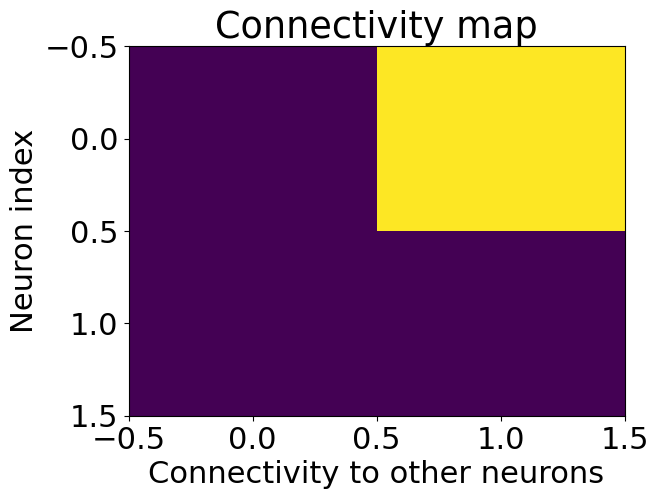

1 comes before 0, weights should decrease:
[[0.05 0.05]
 [0.05 0.05]]
C: LTP on 0 -> 1 at eulerstep 0 of time 99.9999999999986
A: LTD on 0 -> 1 at eulerstep 0 of time 119.99999999999746


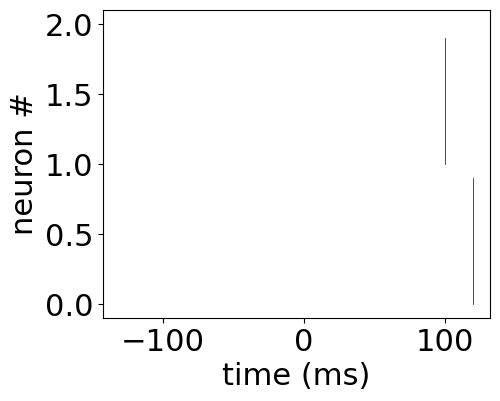

[[0.05       0.04585911]
 [0.05       0.05      ]]
C: LTP on 0 -> 1 at eulerstep 0 of time 279.99999999999517
A: LTD on 0 -> 1 at eulerstep 0 of time 299.9999999999997


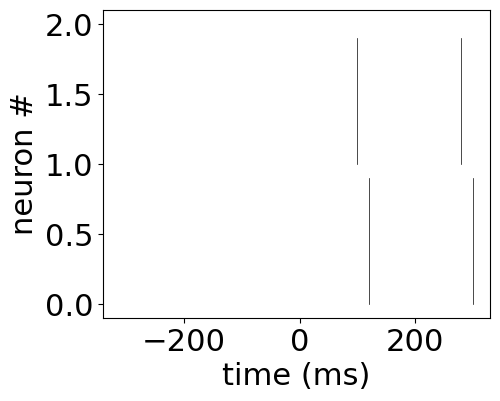

[[0.05       0.04171823]
 [0.05       0.05      ]]
C: LTP on 0 -> 1 at eulerstep 0 of time 460.0000000000361
A: LTD on 0 -> 1 at eulerstep 0 of time 480.00000000004064


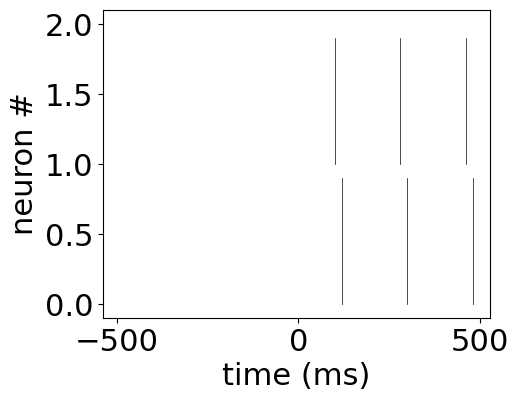

[[0.05       0.03757734]
 [0.05       0.05      ]]



0 comes before 1, weights should increase:


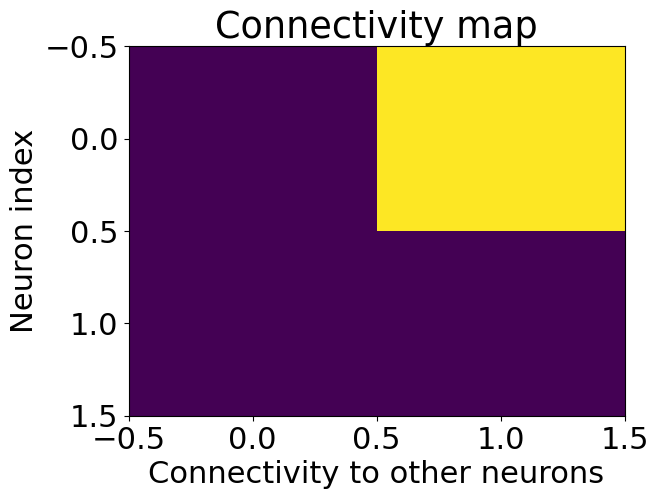

[[0.05 0.05]
 [0.05 0.05]]
A: LTD on 0 -> 1 at eulerstep 0 of time 249.99999999999008
C: LTP on 0 -> 1 at eulerstep 0 of time 279.99999999999517


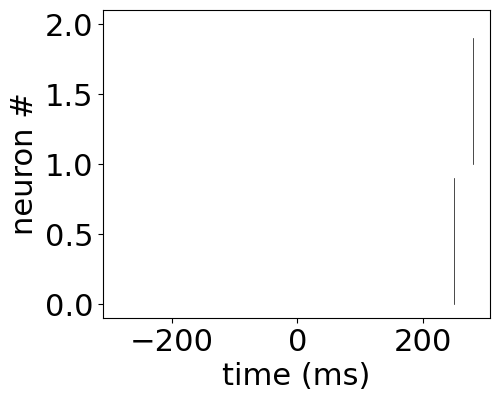

[[0.05       0.05110046]
 [0.05       0.05      ]]
A: LTD on 0 -> 1 at eulerstep 0 of time 432.00000000002973
C: LTP on 0 -> 1 at eulerstep 0 of time 462.00000000003655


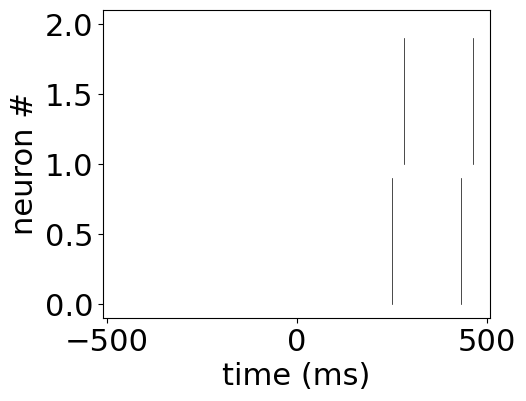

[[0.05      0.0520482]
 [0.05      0.05     ]]
A: LTD on 0 -> 1 at eulerstep 0 of time 614.000000000071
C: LTP on 0 -> 1 at eulerstep 0 of time 644.0000000000779


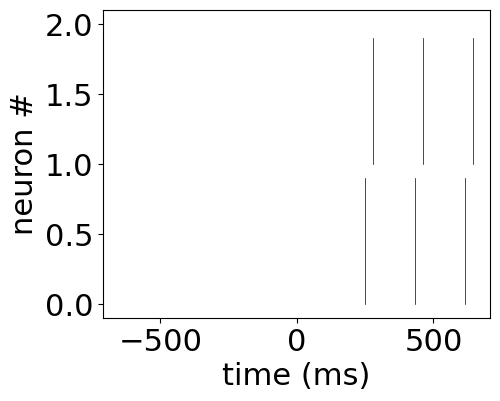

[[0.05       0.05299594]
 [0.05       0.05      ]]


In [32]:
LIF = LIF_Network(n_neurons=2, dimensions= [[0,100],[0,100],[0,50]])
LIF.v_rest = -43  
LIF.v = np.zeros([LIF.n_neurons,]) - 60
LIF.synaptic_delay = 1
LIF.network_conn = np.zeros([LIF.n_neurons,LIF.n_neurons]) 
LIF.network_conn[0][1] = 1
LIF.network_W = np.zeros([LIF.n_neurons,LIF.n_neurons]) + .05
plot_connectivity(LIF)

simulation_results = LIF.simulate(timesteps = 100)
print("========================================")
print("1 comes before 0, weights should decrease:")
print(LIF.network_W)

for i in range(3):
  LIF.v[1] = -35
  simulation_results = LIF.simulate(timesteps = 20)
  LIF.v[0] = -35
  simulation_results = LIF.simulate(timesteps = 10)
  LIF.spikeTrain(nNeurons = 2)
  simulation_results = LIF.simulate(timesteps = 150)
  print(LIF.network_W)

print("")
print("")
print("")
print("========================================")
print("0 comes before 1, weights should increase:")

LIF = LIF_Network(n_neurons=2, dimensions= [[0,100],[0,100],[0,50]])
LIF.v_rest = -43  
LIF.v = np.zeros([LIF.n_neurons,]) - 60
LIF.synaptic_delay = 1
LIF.network_conn = np.zeros([LIF.n_neurons,LIF.n_neurons]) 
LIF.network_conn[0][1] = 1
LIF.network_W = np.zeros([LIF.n_neurons,LIF.n_neurons]) + .05
plot_connectivity(LIF)

simulation_results = LIF.simulate(timesteps = 100)

simulation_results = LIF.simulate(timesteps = 150)
print(LIF.network_W)
for i in range(3):
  LIF.v[0] = -35
  simulation_results = LIF.simulate(timesteps = 30)
  LIF.v[1] = -35
  simulation_results = LIF.simulate(timesteps = 2)
  LIF.spikeTrain(nNeurons = 2)
  simulation_results = LIF.simulate(timesteps = 150)
  print(LIF.network_W)

## Case 2 | Neuron 0 -> 1 | Only neuron 0 Fires

1. 1 comes before 0
    - Weight correctly decreased, LTD
    - From the print statments C and A, we see that LTD was performed on connection 0->1 twice.
2. 0 comes before 1
    - Weight correctly increase, LTP
    - From the print statement A and C, we see that LTP was performed on connection 0->1 twice.

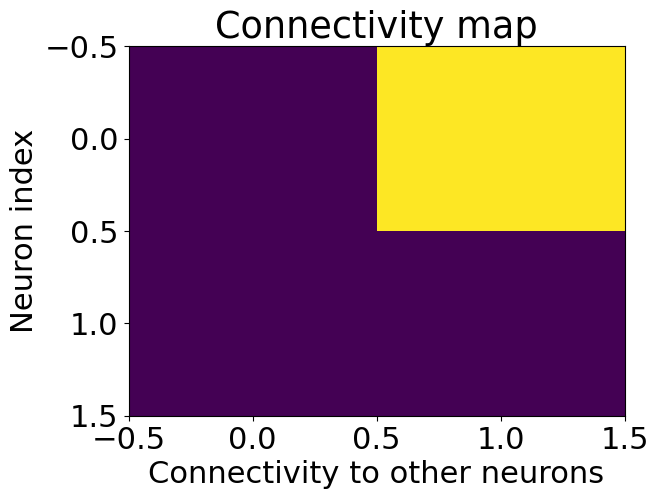

1 comes before 0, weights should decrease:
[[0.05 0.05]
 [0.05 0.05]]
           119.99999999999746 - -10000.0 + 1
A: STDP on 0 -> 1 at eulerstep 0 of time 119.99999999999746 ms
           119.99999999999746 - -10000.0 + 1
           t_spike2[0]-t_spike2[1]: temporal_diff: 10120.999999999998 ms
           LTD, dW = -9.072704299534351e-113


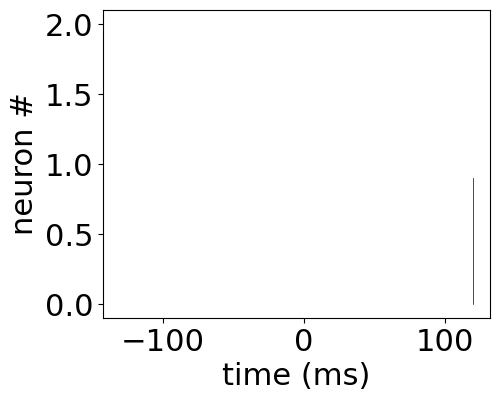

[[0.05 0.05]
 [0.05 0.05]]
           299.9999999999997 - -10000.0 + 1
A: STDP on 0 -> 1 at eulerstep 0 of time 299.9999999999997 ms
           299.9999999999997 - -10000.0 + 1
           t_spike2[0]-t_spike2[1]: temporal_diff: 10301.0 ms
           LTD, dW = -1.0078864065602033e-114
C: STDP on 0 -> 1 at eulerstep 27 of time 302.70000000000033 ms
           t_spike2[0]-t_spike2[1]: temporal_diff: -1.700000000000614 ms
           LTP, dW = 0.01687329633192664


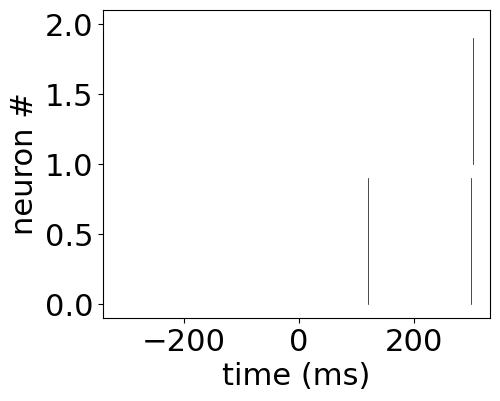

[[0.05      0.0668733]
 [0.05      0.05     ]]
           480.00000000004064 - 302.70000000000033 + 1
A: STDP on 0 -> 1 at eulerstep 0 of time 480.00000000004064 ms
           480.00000000004064 - 302.70000000000033 + 1
           t_spike2[0]-t_spike2[1]: temporal_diff: 178.3000000000403 ms
           LTD, dW = -8.113913750732964e-05


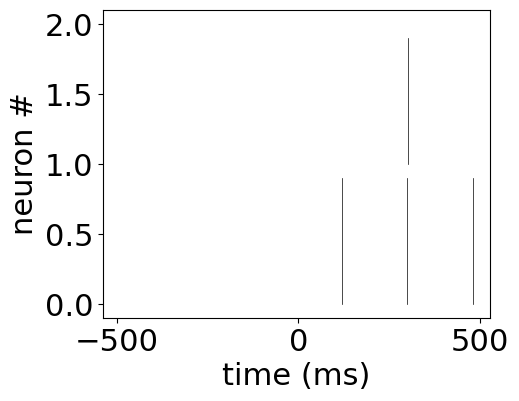

[[0.05       0.06679216]
 [0.05       0.05      ]]
           660.0000000000815 - 302.70000000000033 + 1
A: STDP on 0 -> 1 at eulerstep 0 of time 660.0000000000815 ms
           660.0000000000815 - 302.70000000000033 + 1
           t_spike2[0]-t_spike2[1]: temporal_diff: 358.3000000000812 ms
           LTD, dW = -9.0137439768397e-07
C: STDP on 0 -> 1 at eulerstep 25 of time 662.5000000000821 ms
           t_spike2[0]-t_spike2[1]: temporal_diff: -1.5000000000005684 ms
           LTP, dW = 0.017214159528500177


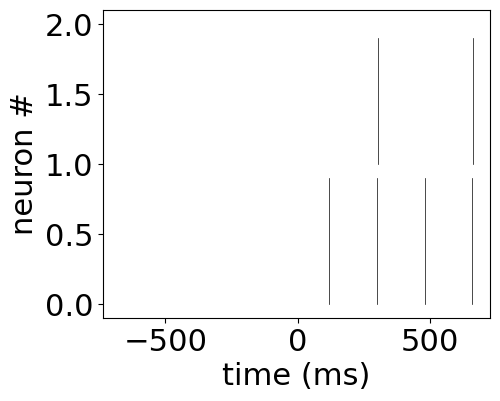

[[0.05       0.08400542]
 [0.05       0.05      ]]
           840.0000000001224 - 662.5000000000821 + 1
A: STDP on 0 -> 1 at eulerstep 0 of time 840.0000000001224 ms
           840.0000000001224 - 662.5000000000821 + 1
           t_spike2[0]-t_spike2[1]: temporal_diff: 178.50000000004036 ms
           LTD, dW = -8.073445437072388e-05


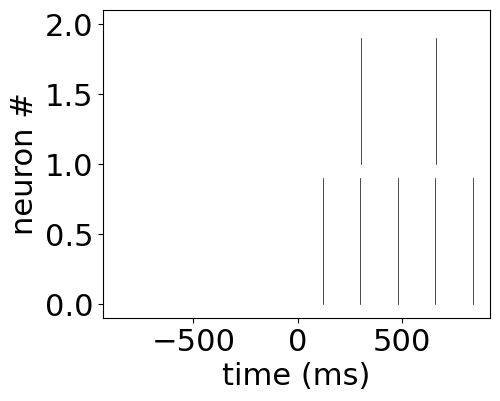

[[0.05       0.08392468]
 [0.05       0.05      ]]



0 comes before 1, weights should increase:


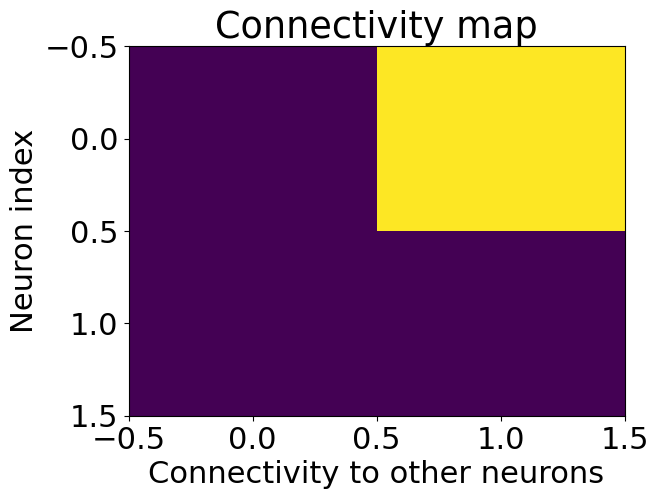

[[0.05 0.05]
 [0.05 0.05]]
           249.99999999999008 - -10000.0 + 1
A: STDP on 0 -> 1 at eulerstep 0 of time 249.99999999999008 ms
           249.99999999999008 - -10000.0 + 1
           t_spike2[0]-t_spike2[1]: temporal_diff: 10250.99999999999 ms
           LTD, dW = -3.5178692210597275e-114


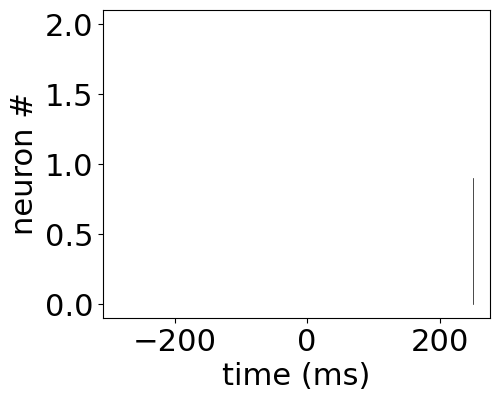

[[0.05 0.05]
 [0.05 0.05]]
           432.00000000002973 - -10000.0 + 1
A: STDP on 0 -> 1 at eulerstep 0 of time 432.00000000002973 ms
           432.00000000002973 - -10000.0 + 1
           t_spike2[0]-t_spike2[1]: temporal_diff: 10433.00000000003 ms
           LTD, dW = -3.717404305456633e-116
C: STDP on 0 -> 1 at eulerstep 21 of time 434.1000000000302 ms
           t_spike2[0]-t_spike2[1]: temporal_diff: -1.1000000000004775 ms
           LTP, dW = 0.01791668270592971


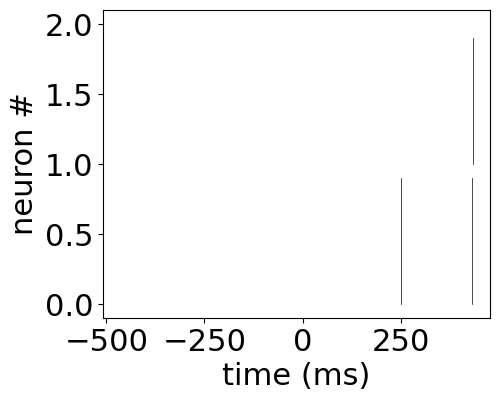

[[0.05       0.06791668]
 [0.05       0.05      ]]
           614.000000000071 - 434.1000000000302 + 1
A: STDP on 0 -> 1 at eulerstep 0 of time 614.000000000071 ms
           614.000000000071 - 434.1000000000302 + 1
           t_spike2[0]-t_spike2[1]: temporal_diff: 180.90000000004085 ms
           LTD, dW = -7.603284576462268e-05


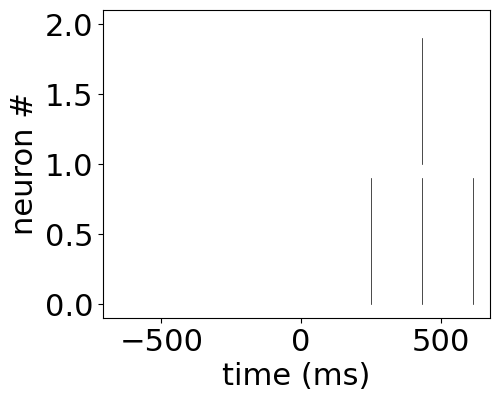

[[0.05       0.06784065]
 [0.05       0.05      ]]
           796.0000000001124 - 434.1000000000302 + 1
A: STDP on 0 -> 1 at eulerstep 0 of time 796.0000000001124 ms
           796.0000000001124 - 434.1000000000302 + 1
           t_spike2[0]-t_spike2[1]: temporal_diff: 362.90000000008223 ms
           LTD, dW = -8.034546210798829e-07
C: STDP on 0 -> 1 at eulerstep 19 of time 797.9000000001129 ms
           t_spike2[0]-t_spike2[1]: temporal_diff: -0.900000000000432 ms
           LTP, dW = 0.018278623705423772


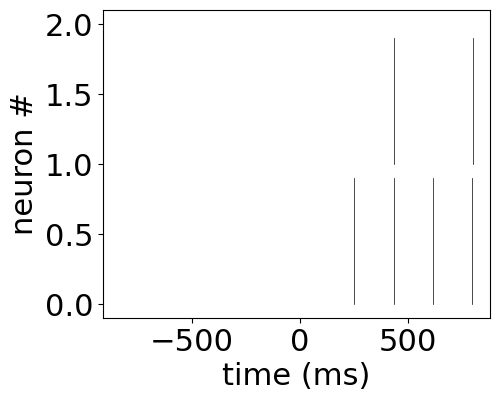

[[0.05       0.08611847]
 [0.05       0.05      ]]
           978.0000000001538 - 797.9000000001129 + 1
A: STDP on 0 -> 1 at eulerstep 0 of time 978.0000000001538 ms
           978.0000000001538 - 797.9000000001129 + 1
           t_spike2[0]-t_spike2[1]: temporal_diff: 181.10000000004095 ms
           LTD, dW = -7.565363036433186e-05


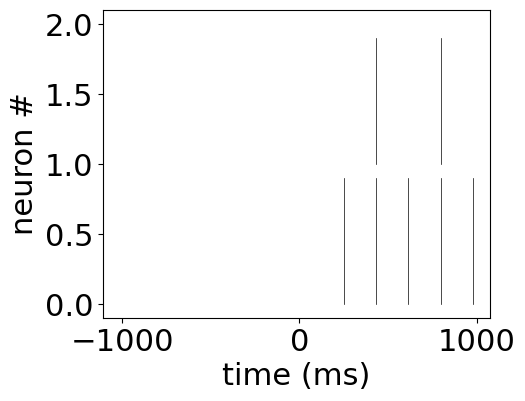

[[0.05       0.08604282]
 [0.05       0.05      ]]


In [27]:
LIF = LIF_Network(n_neurons=2, dimensions= [[0,100],[0,100],[0,50]])
LIF.v_rest = -43  
LIF.v = np.zeros([LIF.n_neurons,]) - 60
LIF.synaptic_delay = 1
LIF.network_conn = np.zeros([LIF.n_neurons,LIF.n_neurons]) 
LIF.network_conn[0][1] = 1
LIF.network_W = np.zeros([LIF.n_neurons,LIF.n_neurons]) + .05
plot_connectivity(LIF)

simulation_results = LIF.simulate(timesteps = 100)
print("========================================")
print("1 comes before 0, weights should decrease:")
print(LIF.network_W)

for i in range(5):
  # LIF.v[1] = -35
  simulation_results = LIF.simulate(timesteps = 20)
  LIF.v[0] = -35
  simulation_results = LIF.simulate(timesteps = 10)
  LIF.spikeTrain(nNeurons = 2)
  simulation_results = LIF.simulate(timesteps = 150)
  print(LIF.network_W)

print("")
print("")
print("")
print("========================================")
print("0 comes before 1, weights should increase:")

LIF = LIF_Network(n_neurons=2, dimensions= [[0,100],[0,100],[0,50]])
LIF.v_rest = -43  
LIF.v = np.zeros([LIF.n_neurons,]) - 60
LIF.synaptic_delay = 1
LIF.network_conn = np.zeros([LIF.n_neurons,LIF.n_neurons]) 
LIF.network_conn[0][1] = 1
LIF.network_W = np.zeros([LIF.n_neurons,LIF.n_neurons]) + .05
plot_connectivity(LIF)

simulation_results = LIF.simulate(timesteps = 100)

simulation_results = LIF.simulate(timesteps = 150)
print(LIF.network_W)
for i in range(5):
  LIF.v[0] = -35
  simulation_results = LIF.simulate(timesteps = 30)
#   LIF.v[1] = -35
  simulation_results = LIF.simulate(timesteps = 2)
  LIF.spikeTrain(nNeurons = 2)
  simulation_results = LIF.simulate(timesteps = 150)
  print(LIF.network_W)

/opt/homebrew/Caskroom/miniconda/base/envs/ds/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniconda/base/envs/ds/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


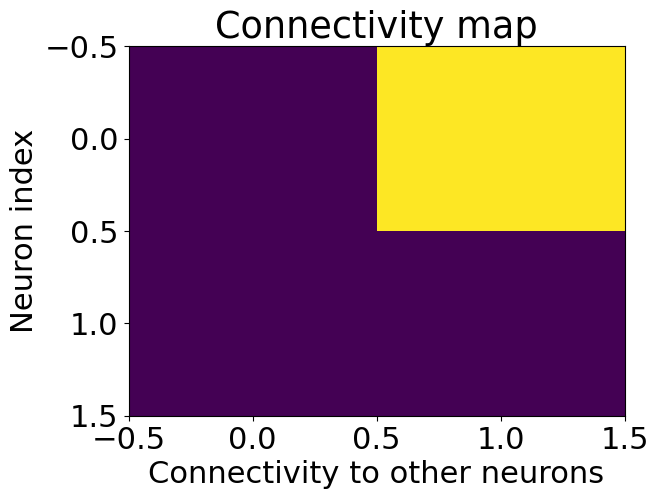

[[0.05 0.05]
 [0.05 0.05]]
           99.9999999999986 - 99.9999999999986 + 9
A: STDP on 0 -> 1 at eulerstep 0 of time 99.9999999999986 ms
           99.9999999999986 - 99.9999999999986 + 9
           t_spike2[0]-t_spike2[1]: temporal_diff: 9.0 ms
           LTD, dW = -0.005589613531315639
D: STDP on 0 -> 1 at eulerstep 0 of time 99.9999999999986 ms
           -10000.0 - 99.9999999999986 + 9
           t_spike1[0]-t_spike2[1]: temporal_diff: -10090.999999999998 ms
           LTP, dW = 0.0


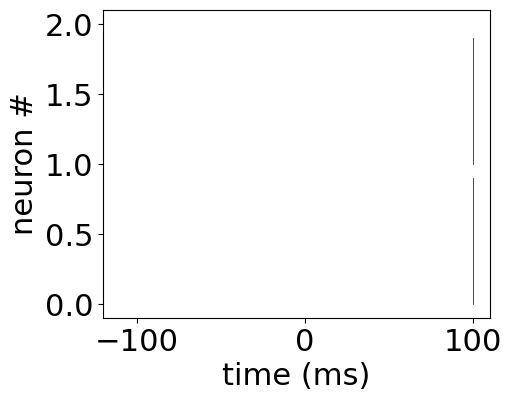

[[0.05       0.04441039]
 [0.05       0.05      ]]
           209.99999999999235 - 209.99999999999235 + 9
A: STDP on 0 -> 1 at eulerstep 0 of time 209.99999999999235 ms
           209.99999999999235 - 209.99999999999235 + 9
           t_spike2[0]-t_spike2[1]: temporal_diff: 9.0 ms
           LTD, dW = -0.005589613531315639
D: STDP on 0 -> 1 at eulerstep 0 of time 209.99999999999235 ms
           99.9999999999986 - 209.99999999999235 + 9
           t_spike1[0]-t_spike2[1]: temporal_diff: -100.99999999999376 ms
           LTP, dW = 8.215911045065268e-07


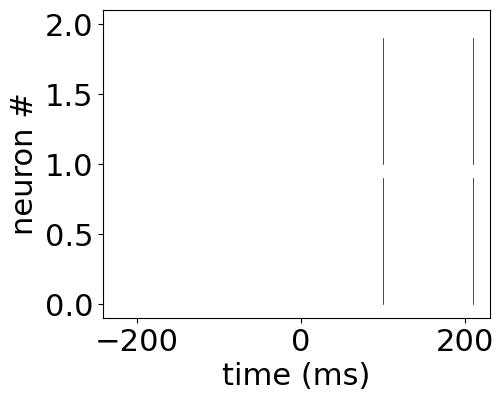

[[0.05       0.03882159]
 [0.05       0.05      ]]
           320.00000000000426 - 320.00000000000426 + 9
A: STDP on 0 -> 1 at eulerstep 0 of time 320.00000000000426 ms
           320.00000000000426 - 320.00000000000426 + 9
           t_spike2[0]-t_spike2[1]: temporal_diff: 9.0 ms
           LTD, dW = -0.005589613531315639
D: STDP on 0 -> 1 at eulerstep 0 of time 320.00000000000426 ms
           209.99999999999235 - 320.00000000000426 + 9
           t_spike1[0]-t_spike2[1]: temporal_diff: -101.00000000001191 ms
           LTP, dW = 8.215911045050352e-07


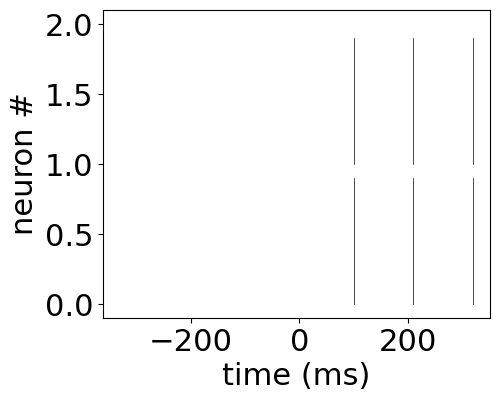

[[0.05      0.0332328]
 [0.05      0.05     ]]


In [26]:
LIF = LIF_Network(n_neurons=2, dimensions= [[0,100],[0,100],[0,50]])
LIF.v_rest = -43  
LIF.v = np.zeros([LIF.n_neurons,]) - 60
# LIF.synaptic_delay = 0   # ??? Why is this zero? 
LIF.synaptic_delay = 9  # Changed to this
LIF.network_conn = np.zeros([LIF.n_neurons,LIF.n_neurons]) 
LIF.network_conn[0][1] = 1
LIF.network_W = np.zeros([LIF.n_neurons,LIF.n_neurons]) + .05
plot_connectivity(LIF)

simulation_results = LIF.simulate(timesteps = 100)
print(LIF.network_W)

for i in range(3):
  LIF.v[0] = -35
  LIF.v[1] = -35
  simulation_results = LIF.simulate(timesteps = 10)
  LIF.spikeTrain(nNeurons = 2)
  simulation_results = LIF.simulate(timesteps = 100)
  print(LIF.network_W)

## Case | Neuron 0 <-> 1 | Both Fires

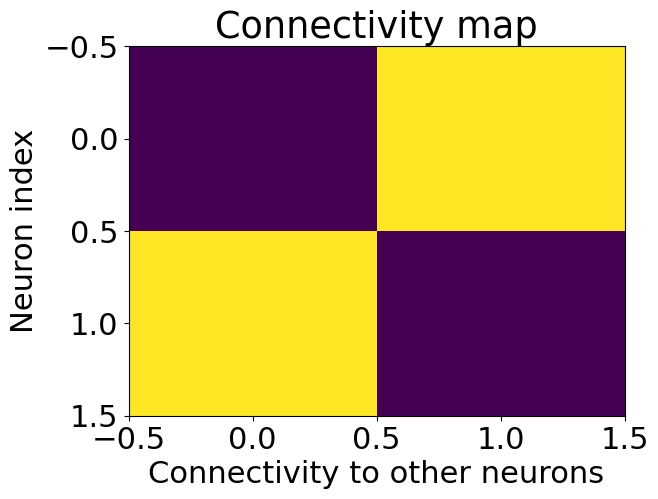

  t_spike1: [-10000. -10000.]
  t_spike2: [-10000. -10000.]
[[0.05 0.05]
 [0.05 0.05]]
A: STDP on 0 -> 1 at eulerstep 0 of time 99.9999999999986 ms
           99.9999999999986 - 99.9999999999986 + 9
           t_spike2[0]-t_spike2[1]: temporal_diff: 9.0 ms
           LTD, dW = -0.005589613531315639
D: STDP on 1 -> 0 at eulerstep 0 of time 99.9999999999986 ms
           -10000.0 - 99.9999999999986 + 9
           t_spike1[1]-t_spike2[0]: temporal_diff: -10090.999999999998 ms
           LTP, dW = 0.0
A: STDP on 1 -> 0 at eulerstep 0 of time 99.9999999999986 ms
           99.9999999999986 - 99.9999999999986 + 9
           t_spike2[1]-t_spike2[0]: temporal_diff: 9.0 ms
           LTD, dW = -0.005589613531315639
D: STDP on 0 -> 1 at eulerstep 0 of time 99.9999999999986 ms
           -10000.0 - 99.9999999999986 + 9
           t_spike1[0]-t_spike2[1]: temporal_diff: -10090.999999999998 ms
           LTP, dW = 0.0


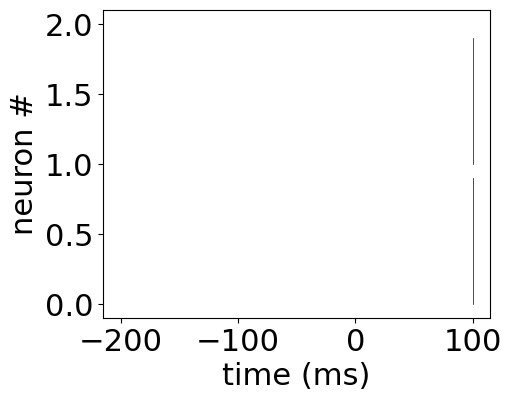

[[0.05       0.04441039]
 [0.04441039 0.05      ]]
A: STDP on 0 -> 1 at eulerstep 0 of time 1200.000000000004 ms
           1200.000000000004 - 1200.000000000004 + 9
           t_spike2[0]-t_spike2[1]: temporal_diff: 9.0 ms
           LTD, dW = -0.005589613531315639
D: STDP on 1 -> 0 at eulerstep 0 of time 1200.000000000004 ms
           99.9999999999986 - 1200.000000000004 + 9
           t_spike1[1]-t_spike2[0]: temporal_diff: -1091.0000000000055 ms
           LTP, dW = 8.308105830135829e-50
A: STDP on 1 -> 0 at eulerstep 0 of time 1200.000000000004 ms
           1200.000000000004 - 1200.000000000004 + 9
           t_spike2[1]-t_spike2[0]: temporal_diff: 9.0 ms
           LTD, dW = -0.005589613531315639
D: STDP on 0 -> 1 at eulerstep 0 of time 1200.000000000004 ms
           99.9999999999986 - 1200.000000000004 + 9
           t_spike1[0]-t_spike2[1]: temporal_diff: -1091.0000000000055 ms
           LTP, dW = 8.308105830135829e-50


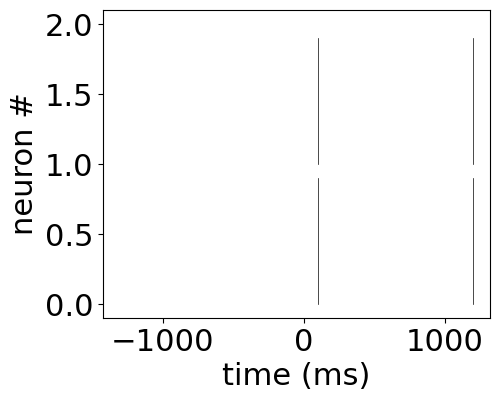

[[0.05       0.03882077]
 [0.03882077 0.05      ]]
A: STDP on 0 -> 1 at eulerstep 0 of time 2299.9999999990036 ms
           2299.9999999990036 - 2299.9999999990036 + 9
           t_spike2[0]-t_spike2[1]: temporal_diff: 9.0 ms
           LTD, dW = -0.005589613531315639
D: STDP on 1 -> 0 at eulerstep 0 of time 2299.9999999990036 ms
           1200.000000000004 - 2299.9999999990036 + 9
           t_spike1[1]-t_spike2[0]: temporal_diff: -1090.9999999989996 ms
           LTP, dW = 8.308105830971614e-50
A: STDP on 1 -> 0 at eulerstep 0 of time 2299.9999999990036 ms
           2299.9999999990036 - 2299.9999999990036 + 9
           t_spike2[1]-t_spike2[0]: temporal_diff: 9.0 ms
           LTD, dW = -0.005589613531315639
D: STDP on 0 -> 1 at eulerstep 0 of time 2299.9999999990036 ms
           1200.000000000004 - 2299.9999999990036 + 9
           t_spike1[0]-t_spike2[1]: temporal_diff: -1090.9999999989996 ms
           LTP, dW = 8.308105830971614e-50


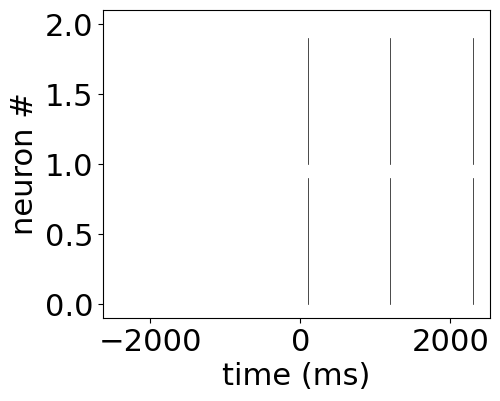

[[0.05       0.03323116]
 [0.03323116 0.05      ]]


In [20]:
LIF = LIF_Network(n_neurons=2, dimensions= [[0,100],[0,100],[0,50]])
LIF.v_rest = -43  
LIF.v = np.zeros([LIF.n_neurons,]) - 60
LIF.synaptic_delay = 9
LIF.network_conn = np.zeros([LIF.n_neurons,LIF.n_neurons]) 
LIF.network_conn[0][1] = 1
LIF.network_conn[1][0] = 1
LIF.network_W = np.zeros([LIF.n_neurons,LIF.n_neurons]) + .05
plot_connectivity(LIF)

simulation_results = LIF.simulate(timesteps = 100)
print(f"  t_spike1: {LIF.t_spike1}")
print(f"  t_spike2: {LIF.t_spike2}")
print(LIF.network_W)

for i in range(3):
  LIF.v[0] = -35
  LIF.v[1] = -35
  simulation_results = LIF.simulate(timesteps = 100)
  LIF.spikeTrain(nNeurons = 2)
  simulation_results = LIF.simulate(timesteps = 1000)
  print(LIF.network_W)

## Case | 0 -> 1 -> 2 -> 3

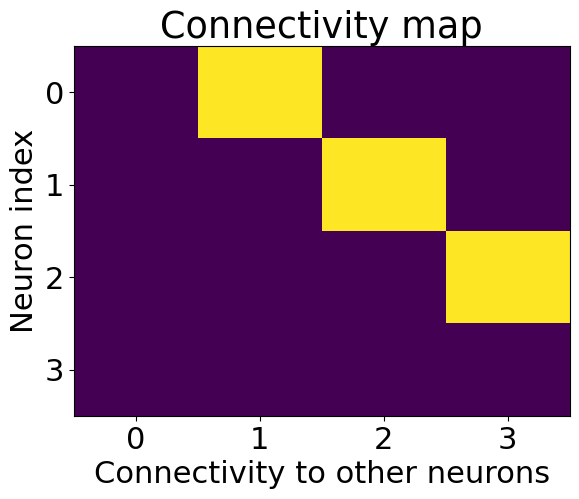

  t_spike1: [-10000. -10000. -10000. -10000.]
  t_spike2: [-10000. -10000. -10000. -10000.]
[[0.05 0.05 0.05 0.05]
 [0.05 0.05 0.05 0.05]
 [0.05 0.05 0.05 0.05]
 [0.05 0.05 0.05 0.05]]
           99.9999999999986 - 99.9999999999986 + 9
A: STDP on 0 -> 1 at eulerstep 0 of time 99.9999999999986 ms
           99.9999999999986 - 99.9999999999986 + 9
           t_spike2[0]-t_spike2[1]: temporal_diff: 9.0 ms
           LTD, dW = -0.005589613531315639
D: STDP on 0 -> 1 at eulerstep 0 of time 99.9999999999986 ms
           -10000.0 - 99.9999999999986 + 9
           t_spike1[0]-t_spike2[1]: temporal_diff: -10090.999999999998 ms
           LTP, dW = 0.0
           99.9999999999986 - 99.9999999999986 + 9
A: STDP on 1 -> 2 at eulerstep 0 of time 99.9999999999986 ms
           99.9999999999986 - 99.9999999999986 + 9
           t_spike2[1]-t_spike2[2]: temporal_diff: 9.0 ms
           LTD, dW = -0.005589613531315639
D: STDP on 1 -> 2 at eulerstep 0 of time 99.9999999999986 ms
           -10000.0 - 9

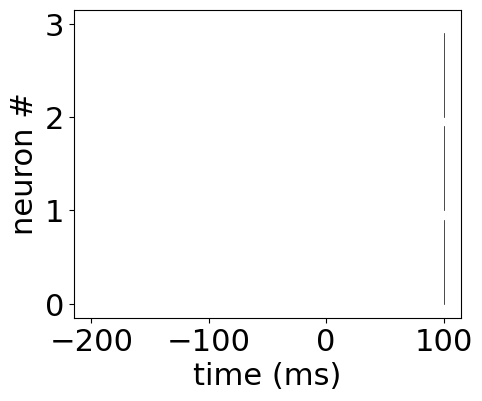

[[0.05       0.04441039 0.05       0.05      ]
 [0.05       0.05       0.04441039 0.05      ]
 [0.05       0.05       0.05       0.05      ]
 [0.05       0.05       0.05       0.05      ]]
           1200.000000000004 - 1200.000000000004 + 9
A: STDP on 0 -> 1 at eulerstep 0 of time 1200.000000000004 ms
           1200.000000000004 - 1200.000000000004 + 9
           t_spike2[0]-t_spike2[1]: temporal_diff: 9.0 ms
           LTD, dW = -0.005589613531315639
D: STDP on 0 -> 1 at eulerstep 0 of time 1200.000000000004 ms
           99.9999999999986 - 1200.000000000004 + 9
           t_spike1[0]-t_spike2[1]: temporal_diff: -1091.0000000000055 ms
           LTP, dW = 8.308105830135829e-50
           1200.000000000004 - 1200.000000000004 + 9
A: STDP on 1 -> 2 at eulerstep 0 of time 1200.000000000004 ms
           1200.000000000004 - 1200.000000000004 + 9
           t_spike2[1]-t_spike2[2]: temporal_diff: 9.0 ms
           LTD, dW = -0.005589613531315639
D: STDP on 1 -> 2 at eulerstep 0 of time 1

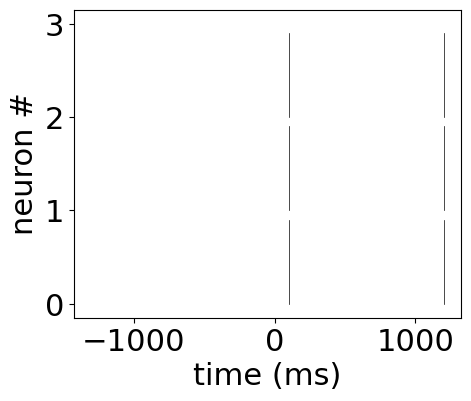

C: STDP on 2 -> 3 at eulerstep 3945 of time 1694.4999999995543 ms
           t_spike2[2]-t_spike2[3]: temporal_diff: -485.49999999955025 ms
           LTP, dW = 1.6444962946708837e-23
[[0.05       0.03882077 0.05       0.05      ]
 [0.05       0.05       0.03882077 0.05      ]
 [0.05       0.05       0.05       0.05      ]
 [0.05       0.05       0.05       0.05      ]]
           2299.9999999990036 - 2299.9999999990036 + 9
A: STDP on 0 -> 1 at eulerstep 0 of time 2299.9999999990036 ms
           2299.9999999990036 - 2299.9999999990036 + 9
           t_spike2[0]-t_spike2[1]: temporal_diff: 9.0 ms
           LTD, dW = -0.005589613531315639
D: STDP on 0 -> 1 at eulerstep 0 of time 2299.9999999990036 ms
           1200.000000000004 - 2299.9999999990036 + 9
           t_spike1[0]-t_spike2[1]: temporal_diff: -1090.9999999989996 ms
           LTP, dW = 8.308105830971614e-50
           2299.9999999990036 - 2299.9999999990036 + 9
A: STDP on 1 -> 2 at eulerstep 0 of time 2299.9999999990036 ms
 

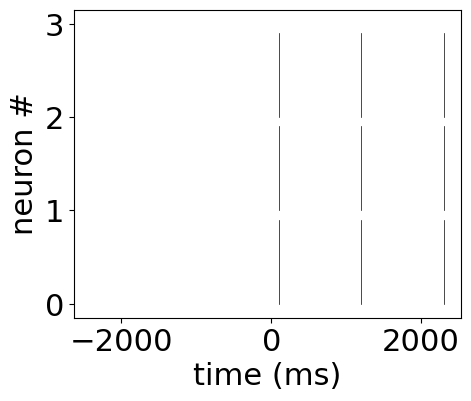

C: STDP on 2 -> 3 at eulerstep 2680 of time 2667.999999998669 ms
           t_spike2[2]-t_spike2[3]: temporal_diff: -358.9999999996653 ms
           LTP, dW = 5.126938351767008e-18
[[0.05       0.03323116 0.05       0.05      ]
 [0.05       0.05       0.03323116 0.05      ]
 [0.05       0.05       0.05       0.05      ]
 [0.05       0.05       0.05       0.05      ]]


In [32]:
LIF = LIF_Network(n_neurons=4, dimensions= [[0,100],[0,100],[0,50]])
LIF.v_rest = -43  
LIF.v = np.zeros([LIF.n_neurons,]) - 60
LIF.synaptic_delay = 9
LIF.network_conn = np.zeros([LIF.n_neurons,LIF.n_neurons]) 
LIF.network_conn[0, 1] = 1
LIF.network_conn[1, 2] = 1
LIF.network_conn[2, 3] = 1
LIF.network_W = np.zeros([LIF.n_neurons,LIF.n_neurons]) + .05
plot_connectivity(LIF)

simulation_results = LIF.simulate(timesteps = 100)
print(f"  t_spike1: {LIF.t_spike1}")
print(f"  t_spike2: {LIF.t_spike2}")
print(LIF.network_W)

for i in range(3):
  LIF.v[0] = -35
  LIF.v[1] = -35
  LIF.v[2] = -35
  simulation_results = LIF.simulate(timesteps = 100)
  LIF.spikeTrain(nNeurons = 3)
  simulation_results = LIF.simulate(timesteps = 1000)
  print(LIF.network_W)